**[Intro to Game AI and Reinforcement Learning Home Page](https://www.kaggle.com/learn/intro-to-game-ai-and-reinforcement-learning)**

---


# Introduction

In the tutorial, you learned a bit about reinforcement learning and used the `stable-baselines` package to train an agent to beat a random opponent.  In this exercise, you will check your understanding and tinker with the code to deepen your intuition.

In [1]:
from learntools.core import binder
binder.bind(globals())
from learntools.game_ai.ex4 import *

### 1) Set the architecture

In the tutorial, you learned one way to design a neural network that can select moves in Connect Four.  The neural network had an output layer with seven nodes: one for each column in the game board.

Say now you wanted to create a neural network that can play chess.  How many nodes should you put in the output layer?

- Option A: 2 nodes (number of game players)
- Option B: 16 nodes (number of game pieces that each player starts with)
- Option C: 4672 nodes (number of possible moves)
- Option D: 64 nodes (number of squares on the game board)

Use your answer to set the value of the `best_option` variable below.  Your answer should be one of `'A'`, `'B'`, `'C'`, or `'D'`.

In [2]:
# Fill in the blank
best_option = 'C'

# Check your answer
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> If we use a similar network as in the tutorial, the network should output a probability for each possible move.

In [3]:
# Lines below will give you solution code
#q_1.solution()

### 2) Decide reward

In the tutorial, you learned how to give your agent a reward that encourages it to win games of Connect Four.  Consider now training an agent to win at the game [Minesweeper](https://bit.ly/2T5xEY8).  The goal of the game is to clear the board without detonating any bombs.

To play this game in Google Search, click on the **[Play]** button at [this link](https://www.google.com/search?q=minesweeper).  

<center>
<img src="https://i.imgur.com/WzoEfKY.png" width=50%><br/>
</center>

With each move, one of the following is true:
- The agent selected an invalid move (in other words, it tried to uncover a square that was uncovered as part of a previous move).  Let's assume this ends the game, and the agent loses.
- The agent clears a square that did not contain a hidden mine.  The agent wins the game, because all squares without mines are revealed.
- The agent clears a square that did not contain a hidden mine, but has not yet won or lost the game.
- The agent detonates a mine and loses the game.

How might you specify the reward for each of these four cases, so that by maximizing the cumulative reward, the agent will try to win the game?

After you have decided on your answer, run the code cell below to get credit for completing this question.

In [4]:
# Check your answer (Run this code cell to receive credit!)
q_2.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> Here's a possible solution - after each move, we give the agent a reward that tells it how well it did:
- If agent wins the game in that move, it gets a reward of `+1`.
- Else if the agent selects an invalid move, it gets a reward of `-10`.
- Else if it detonates a mine, it gets a reward of `-1`.
- Else if the agent clears a square with no hidden mine, it gets a reward of `+1/100`.

To check the validity of your answer, note that the reward for selecting an invalid move and for detonating a mine should both be negative.  The reward for winning the game should be positive.  And, the reward for clearing a square with no hidden mine should be either zero or slightly positive.

### 3) (Optional) Amend the code

In this next part of the exercise, you will amend the code from the tutorial to experiment with creating your own agents!  There are a lot of hyperparameters involved with specifying a reinforcement learning agent, and you'll have a chance to amend them, to see how performance is affected.

First, we'll need to make sure that your Kaggle Notebook is set up to run the code.  Begin by looking at the "Settings" menu to the right of your notebook.  Your menu will look like one of the following:

<center>
<img src="https://i.imgur.com/kR1az0y.png" width=100%><br/>
</center>

If your "Internet" setting appears as a "Requires phone verification" link, click on this link.  This will bring you to a new window; then, follow the instructions to verify your account.  After following this step, your "Internet" setting will appear "Off", as in the example to the right.

Once your "Internet" setting appears as "Off", click to turn it on.  You'll see a pop-up window that you'll need to "Accept" in order to complete the process and have the setting switched to "On".  Once the Internet is turned "On", you're ready to proceed!

<center>
<img src="https://i.imgur.com/gOVh6Aa.png" width=100%><br/>
</center>

Begin by running the code cell below. 

In [5]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

!pip install 'tensorflow==1.15.0'

import tensorflow as tf
from kaggle_environments import make, evaluate
from gym import spaces

!apt-get update
!apt-get install -y cmake libopenmpi-dev python3-dev zlib1g-dev
!pip install "stable-baselines[mpi]==2.9.0"

from stable_baselines.bench import Monitor 
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO1, A2C, ACER, ACKTR, TRPO
from stable_baselines.a2c.utils import conv, linear, conv_to_fc
from stable_baselines.common.policies import CnnPolicy

class ConnectFourGym:
    def __init__(self, agent2="random"):
        ks_env = make("connectx", debug=True)
        self.env = ks_env.train([None, agent2])
        self.rows = ks_env.configuration.rows
        self.columns = ks_env.configuration.columns
        # Learn about spaces here: http://gym.openai.com/docs/#spaces
        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(low=0, high=2, 
                                            shape=(self.rows,self.columns,1), dtype=np.int)
        # Tuple corresponding to the min and max possible rewards
        self.reward_range = (-10, 1)
        # StableBaselines throws error if these are not defined
        self.spec = None
        self.metadata = None
    def reset(self):
        self.obs = self.env.reset()
        return np.array(self.obs['board']).reshape(self.rows,self.columns,1)
    def change_reward(self, old_reward, done):
        if old_reward == 1: # The agent won the game
            return 1
        elif done: # The opponent won the game
            return -1
        else: # Reward 1/42
            return 1/(self.rows*self.columns)
    def step(self, action):
        # Check if agent's move is valid
        is_valid = (self.obs['board'][int(action)] == 0)
        if is_valid: # Play the move
            self.obs, old_reward, done, _ = self.env.step(int(action))
            reward = self.change_reward(old_reward, done)
        else: # End the game and penalize agent
            reward, done, _ = -10, True, {}
        return np.array(self.obs['board']).reshape(self.rows,self.columns,1), reward, done, _
    
# Create ConnectFour environment
env = ConnectFourGym(agent2="random")

# Create directory for logging training information
log_dir = "log/"
os.makedirs(log_dir, exist_ok=True)

# Logging progress
monitor_env = Monitor(env, log_dir, allow_early_resets=True)

# Create a vectorized environment
vec_env = DummyVecEnv([lambda: monitor_env])

# Neural network for predicting action values
def modified_cnn(scaled_images, **kwargs):
    activ = tf.nn.relu
    layer_1 = activ(conv(scaled_images, 'c1', n_filters=32, filter_size=3, stride=1, 
                         init_scale=np.sqrt(2), **kwargs))
    layer_2 = activ(conv(layer_1, 'c2', n_filters=64, filter_size=3, stride=1, 
                         init_scale=np.sqrt(2), **kwargs))
    layer_2 = conv_to_fc(layer_2)
    return activ(linear(layer_2, 'fc1', n_hidden=512, init_scale=np.sqrt(2)))  

class CustomCnnPolicy(CnnPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomCnnPolicy, self).__init__(*args, **kwargs, cnn_extractor=modified_cnn)

     |████████████████████████████████| 412.3 MB 14 kB/s 
     |████████████████████████████████| 503 kB 33.1 MB/s 
     |████████████████████████████████| 3.8 MB 30.5 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7539 sha256=a20a23edc979a5b04c523710a3c366efc24ef0253557eb504f00d4cace386c47
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Attempting uninstall: gast
    Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2

Next, run the code cell below to train an agent with PPO and view how the rewards evolved during training.  This code is identical to the code from the tutorial.

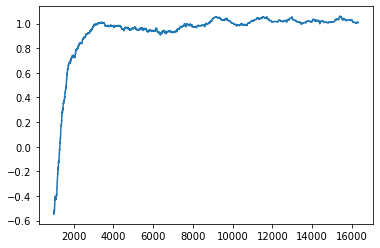

In [6]:
# Initialize agent
model = ACER(CustomCnnPolicy, vec_env, verbose=0)

# Train agent
model.learn(total_timesteps=100000)

# Plot cumulative reward
with open(os.path.join(log_dir, "monitor.csv"), 'rt') as fh:    
    firstline = fh.readline()
    assert firstline[0] == '#'
    df = pd.read_csv(fh, index_col=None)['r']
df.rolling(window=1000).mean().plot()
plt.show()

If your agent trained well, the plot (which shows average cumulative rewards) should increase over time.

Once you have verified that the code runs, try making amendments to see if you can get increased performance.  You might like to:
- change `PPO1` to `A2C` (or `ACER` or `ACKTR` or `TRPO`) when defining the model in this line of code: `model = PPO1(CustomCnnPolicy, vec_env, verbose=0)`.  This will let you see how performance can be affected by changing the algorithm from Proximal Policy Optimization [PPO] to one of:
  - Advantage Actor-Critic (A2C),
  - or Actor-Critic with Experience Replay (ACER),
  - Actor Critic using Kronecker-factored Trust Region (ACKTR), or 
  - Trust Region Policy Optimization (TRPO).
- modify the `change_reward()` method in the `ConnectFourGym` class to change the rewards that the agent receives in different conditions.  You may also need to modify `self.reward_range` in the `__init__` method (this tuple should always correspond to the minimum and maximum reward that the agent can receive).
- change `agent2` to a different agent when creating the ConnectFour environment with `env = ConnectFourGym(agent2="random")`.  For instance, you might like to use the `"negamax"` agent, or a different, custom agent.  Note that the smarter you make the opponent, the harder it will be for your agent to train!

# Congratulations!

You have completed the course, and it's time to put your new skills to work!  

The next step is to apply what you've learned to a **[more complex game: Halite](https://www.kaggle.com/c/halite)**.  For a step-by-step tutorial in how to make your first submission to this competition, **[check out the bonus lesson](https://www.kaggle.com/alexisbcook/getting-started-with-halite)**!

You can find more games as they're released on the **[Kaggle Simulations page](https://www.kaggle.com/simulations)**.

As we did in the course, we recommend that you start simple, with an agent that follows your precise instructions.  This will allow you to learn more about the mechanics of the game and to build intuition for what makes a good agent.  Then, gradually increase the complexity of your agents to climb the leaderboard!

---
**[Intro to Game AI and Reinforcement Learning Home Page](https://www.kaggle.com/learn/intro-to-game-ai-and-reinforcement-learning)**





*Have questions or comments? Visit the [Learn Discussion forum](https://www.kaggle.com/learn-forum) to chat with other Learners.*